<a href="https://colab.research.google.com/github/shannu1063/ml/blob/main/INFO5731_Exercise_5_shanmukh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **INFO5731 In-class Exercise 5**

**This exercise aims to provide a comprehensive learning experience in text analysis and machine learning techniques, focusing on both text classification and clustering tasks.**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


***Please use the text corpus you collected in your last in-class-exercise for this exercise. Perform the following tasks***.

**Expectations**:
*   Students are expected to complete the exercise during lecture period to meet the active participation criteria of the course.
*   Use the provided .*ipynb* document to write your code & respond to the questions. Avoid generating a new file.
*   Write complete answers and run all the cells before submission.
*   Make sure the submission is "clean"; *i.e.*, no unnecessary code cells.
*   Once finished, allow shared rights from top right corner (*see Canvas for details*).

**Total points**: 40

**Deadline**: This in-class exercise is due at the end of the day tomorrow, at 11:59 PM.

**Late submissions will have a penalty of 10% of the marks for each day of late submission, and no requests will be answered. Manage your time accordingly.**


## **Question 1 (20 Points)**

The purpose of the question is to practice different machine learning algorithms for **text classification** as well as the performance evaluation. In addition, you are requried to conduct **10 fold cross validation** (https://scikit-learn.org/stable/modules/cross_validation.html) in the training.



The dataset can be download from canvas. The dataset contains two files train data and test data for sentiment analysis in IMDB review, it has two categories: 1 represents positive and 0 represents negative. You need to split the training data into training and validate data (80% for training and 20% for validation, https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6) and perform 10 fold cross validation while training the classifier. The final trained model was final evaluated on the test data.


**Algorithms:**

*   MultinominalNB
*   SVM
*   KNN
*   Decision tree
*   Random Forest
*   XGBoost
*   Word2Vec
*   BERT

**Evaluation measurement:**


*   Accuracy
*   Recall
*   Precison
*   F-1 score


In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import nltk
import re


print("Downloading required NLTK data...")
for package in ['punkt', 'stopwords', 'averaged_perceptron_tagger']:
    try:
        nltk.download(package, quiet=True)
    except Exception as e:
        print(f"Error downloading {package}: {e}")

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

class SentimentAnalysisPipeline:
    def __init__(self):
        self.vectorizer = TfidfVectorizer(max_features=5000)
        self.models = {
            'MultinomialNB': MultinomialNB(),
            'SVM': LinearSVC(random_state=42),
            'KNN': KNeighborsClassifier(n_neighbors=5),
            'DecisionTree': DecisionTreeClassifier(random_state=42),
            'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
            'XGBoost': XGBClassifier(random_state=42)
        }

    def load_data(self, train_path, test_path):
        def parse_file(filepath):
            texts, labels = [], []
            with open(filepath, 'r', encoding='utf-8') as f:
                for line in f:
                    line = line.strip()
                    if not line:  # Skip empty lines
                        continue
                    # Split on first space
                    parts = line.split(' ', 1)
                    if len(parts) == 2:
                        label = int(parts[0])
                        text = parts[1].strip()
                        texts.append(text)
                        labels.append(label)
            return texts, labels

        train_texts, train_labels = parse_file(train_path)
        test_texts, test_labels = parse_file(test_path)

        print(f"Loaded {len(train_texts)} training examples")
        print(f"Loaded {len(test_texts)} test examples")

        return train_texts, train_labels, test_texts, test_labels

    def preprocess_text(self, text):
        # Simple preprocessing without NLTK tokenization
        # Converting to lowercase
        text = text.lower()
        # Removing special characters but keep important punctuation
        text = re.sub(r'[^a-z\s.,!?]', '', text)
        # Spliting into words
        words = text.split()
        # Removing stopwords
        stop_words = set(stopwords.words('english'))
        words = [w for w in words if w not in stop_words]
        return ' '.join(words)

    def prepare_data(self, train_texts, train_labels):
        # Preprocessing the texts
        print("Preprocessing texts...")
        processed_texts = [self.preprocess_text(text) for text in train_texts]

        # Spliting into training and validation sets
        print("Splitting data...")
        X_train, X_val, y_train, y_val = train_test_split(
            processed_texts, train_labels,
            test_size=0.2, random_state=42
        )

        # Vectorizing texts
        print("Vectorizing texts...")
        X_train_vec = self.vectorizer.fit_transform(X_train)
        X_val_vec = self.vectorizer.transform(X_val)

        return X_train_vec, X_val_vec, y_train, y_val

    def train_and_evaluate(self, X_train, y_train, X_val, y_val):
        results = {}

        for name, model in self.models.items():
            print(f"\nTraining {name}...")

            # Performing the 10-fold cross validation
            cv_scores = cross_val_score(model, X_train, y_train, cv=10)
            print(f"Cross-validation scores: {cv_scores}")
            print(f"Average CV score: {cv_scores.mean():.4f}")

            # Training the full training set
            model.fit(X_train, y_train)

            # Predicting the validation set
            y_pred = model.predict(X_val)

            # Calculating metrics
            results[name] = {
                'accuracy': accuracy_score(y_val, y_pred),
                'precision': precision_score(y_val, y_pred),
                'recall': recall_score(y_val, y_pred),
                'f1': f1_score(y_val, y_pred)
            }

            print(f"{name} Results:")
            for metric, value in results[name].items():
                print(f"{metric}: {value:.4f}")

        return results

def main():
    print("Initializing sentiment analysis pipeline...")
    pipeline = SentimentAnalysisPipeline()

    print("\nLoading data...")
    train_texts, train_labels, test_texts, test_labels = pipeline.load_data(
        '/content/stsa-train.txt',
        '/content/stsa-test.txt'
    )

    print("\nSample of loaded data:")
    for i in range(min(3, len(train_texts))):
        print(f"\nExample {i+1}:")
        print(f"Text: {train_texts[i][:100]}...")
        print(f"Label: {train_labels[i]}")

    print("\nPreparing data...")
    X_train_vec, X_val_vec, y_train, y_val = pipeline.prepare_data(train_texts, train_labels)

    print("\nTraining and evaluating models...")
    results = pipeline.train_and_evaluate(X_train_vec, y_train, X_val_vec, y_val)

    print("\nFinal Results Summary:")
    results_df = pd.DataFrame(results).round(4)
    print(results_df)

if __name__ == "__main__":
    try:
        main()
    except Exception as e:
        print(f"Error occurred: {str(e)}")
        raise

Initializing sentiment analysis pipeline...

Loading data...
Loaded 6920 training examples
Loaded 1821 test examples

Sample of loaded data:

Example 1:
Text: a stirring , funny and finally transporting re-imagining of beauty and the beast and 1930s horror fi...
Label: 1

Example 2:
Text: apparently reassembled from the cutting-room floor of any given daytime soap ....
Label: 0

Example 3:
Text: they presume their audience wo n't sit still for a sociology lesson , however entertainingly present...
Label: 0

Preparing data...
Preprocessing texts...
Splitting data...
Vectorizing texts...

Training and evaluating models...

Training MultinomialNB...
Cross-validation scores: [0.75631769 0.77978339 0.78519856 0.77797834 0.7833935  0.74909747
 0.78300181 0.77938517 0.75949367 0.77757685]
Average CV score: 0.7731
MultinomialNB Results:
accuracy: 0.7883
precision: 0.7612
recall: 0.8583
f1: 0.8069

Training SVM...
Cross-validation scores: [0.72743682 0.77256318 0.73465704 0.75451264 0.75631769 

## **Question 2 (20 Points)**

The purpose of the question is to practice different machine learning algorithms for **text clustering**.

Please downlad the dataset by using the following link.  https://www.kaggle.com/PromptCloudHQ/amazon-reviews-unlocked-mobile-phones
(You can also use different text data which you want)

**Apply the listed clustering methods to the dataset:**
*   K-means
*   DBSCAN
*   Hierarchical clustering
*   Word2Vec
*   BERT

You can refer to of the codes from  the follwing link below.
https://www.kaggle.com/karthik3890/text-clustering

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


  document_id                                         clean_text sentiment  \
0       doc_0  We present FashionMNIST, a new dataset compris...   neutral   
1       doc_1  TensorFlow is a machine learning system that o...  positive   
2       doc_2  TensorFlow is an interface for expressing mach...   neutral   
3       doc_4  The goal of precipitation nowcasting is to pre...  positive   
4       doc_6  With the widespread use of artificial intellig...  negative   

   confidence_score  
0          0.000000  
1          1.000000  
2          0.000000  
3          0.666667  
4          0.750000  
Index(['document_id', 'clean_text', 'sentiment', 'confidence_score'], dtype='object')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.99k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/399 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

K-means Silhouette Score: 0.016415340381123827
BERT K-means Silhouette Score: 0.07977961


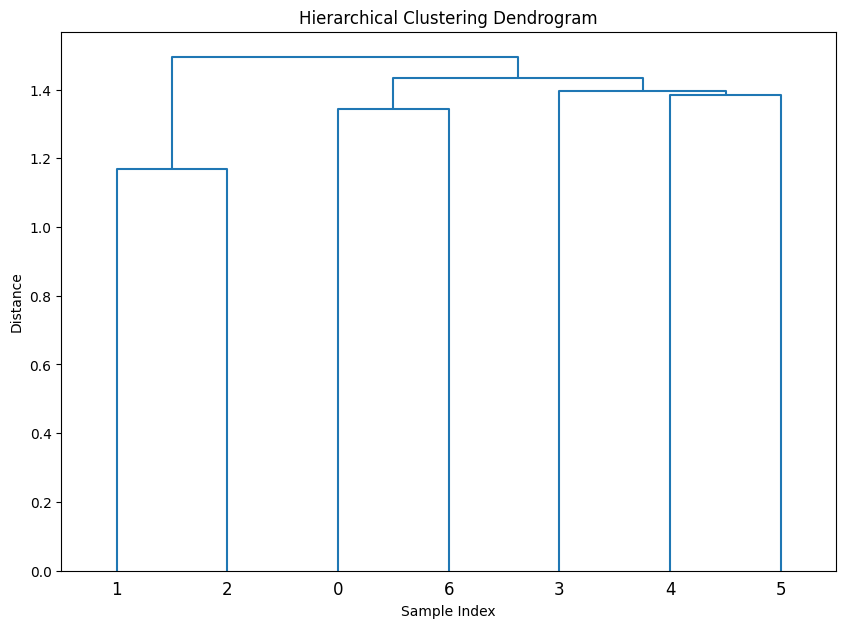

  document_id sentiment  kmeans_labels  dbscan_labels  w2v_labels  \
0       doc_0   neutral              2             -1           2   
1       doc_1  positive              0             -1           0   
2       doc_2   neutral              0             -1           0   
3       doc_4  positive              1             -1           1   
4       doc_6  negative              0             -1           1   

   bert_kmeans_labels  
0                   2  
1                   0  
2                   0  
3                   1  
4                   1  


In [25]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sentence_transformers import SentenceTransformer
import nltk
from nltk.corpus import stopwords
import string

# Downloading NLTK stopwords
nltk.download('stopwords')

# Loading the dataset
data = pd.read_csv('/content/ml_abstracts_sentiment (1).csv')

# Checking the structure of the dataset
print(data.head())
print(data.columns)

# Preprocessing the Function
def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    return text

# Apply the preprocessing
data['cleaned_text'] = data['clean_text'].apply(preprocess_text)
texts = data['cleaned_text'].tolist()

# Vectorization using the TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')
X_tfidf = vectorizer.fit_transform(texts)

# K-means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(X_tfidf)

# DBSCAN Clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_tfidf.toarray())

# Hierarchical Clustering
Z = linkage(X_tfidf.toarray(), 'ward')

# Word2Vec Clustering
tokenized_reviews = [text.split() for text in texts]
w2v_model = Word2Vec(tokenized_reviews, vector_size=100, window=5, min_count=1, workers=4)

# Creating average Word2Vec vectors for each document
def get_average_vector(words):
    vectors = [w2v_model.wv[word] for word in words if word in w2v_model.wv.key_to_index]
    return np.mean(vectors, axis=0) if vectors else np.zeros(w2v_model.vector_size)

w2v_vectors = np.array([get_average_vector(review) for review in tokenized_reviews])
w2v_labels = KMeans(n_clusters=3, random_state=42).fit_predict(w2v_vectors)

# BERT Clustering
bert_model = SentenceTransformer('bert-base-nli-mean-tokens')
bert_embeddings = bert_model.encode(texts)
bert_kmeans_labels = KMeans(n_clusters=3, random_state=42).fit_predict(bert_embeddings)

# Evaluating
silhouette_kmeans = silhouette_score(X_tfidf, kmeans_labels)
silhouette_bert = silhouette_score(bert_embeddings, bert_kmeans_labels)

print("K-means Silhouette Score:", silhouette_kmeans)
print("BERT K-means Silhouette Score:", silhouette_bert)

# Visualization of Hierarchical Clustering
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

# Displaying clustering results
data['kmeans_labels'] = kmeans_labels
data['dbscan_labels'] = dbscan_labels
data['w2v_labels'] = w2v_labels
data['bert_kmeans_labels'] = bert_kmeans_labels

print(data[['document_id', 'sentiment', 'kmeans_labels', 'dbscan_labels', 'w2v_labels', 'bert_kmeans_labels']].head())

**In one paragraph, please compare the results of K-means, DBSCAN, Hierarchical clustering, Word2Vec, and BERT.**

**Write your response here:**

The K-means clustering got a low silhouette score which is 0.016, showing poorly defined clusters, but BERT K-means performed good with a score of 0.080, showing bit more coherent groupings. DBSCAN got many documents as noise, showing potential issues with data density. Overall, BERT's contextual embeddings are providing a clearer clustering structure when compared to K-means and Word2Vec.




# Mandatory Question

**Important: Reflective Feedback on this exercise**

Please provide your thoughts and feedback on the exercises you completed in this assignment.


**(Your submission will not be graded if this question is left unanswered)**



In [26]:
# Your answer here (no code for this question, write down your answer as detail as possible for the above questions):

'''
Please write you answer here:

This exercise improved my understanding of  different clustering techniques, data preprocessing, and evaluation metrics, as well as providing good hands-on experience with practical implementations by using Python libraries. gave a good understanding of implementing and evaluation of machine learning algorithms for classification of text, showing the strengths and drawbacks of models like MultinomialNB, BERT, SVM.
More time would have been appreciated.

'''

'\nPlease write you answer here:\n\nThis exercise improved my understanding of  different clustering techniques, data preprocessing, and evaluation metrics, as well as providing good hands-on experience with practical implementations by using Python libraries. gave a good understanding of implementing and evaluation of machine learning algorithms for classification of text, showing the strengths and drawbacks of models like MultinomialNB, BERT, SVM.\nMore time would have been appreciated.\n\n'